In [1]:
from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from sklearn.preprocessing import MinMaxScaler

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track_unwrapped", "groundspeed", "altitude", "timedelta"],
    init_features=["latitude", "longitude"],
    scaler=MinMaxScaler(feature_range=(-1, 1)),
    mode="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    File location: ../deep_traffic_generation/data/traffic_15.pkl
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_4/checkpoints/epoch=493-step=1481.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_4/hparams.yaml",
    input_dim = dataset.input_dim,
    seq_len=dataset.seq_len,
    scaler = dataset.scaler,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [4]:
z_loc, z_scale = model.encoder(torch.Tensor(dataset.dense))
z_loc.size()

torch.Size([3968, 32])

In [5]:
np.save("../deep_traffic_generation/data/z_loc.npy", z_loc.detach().cpu().numpy())

In [6]:
x = z_loc.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x

array([[-1.3752229 ,  1.90292   ,  0.51922035, ..., -2.0446634 ,
        -0.47703636, -1.0956887 ],
       [ 0.8587121 , -0.30005863, -0.63016653, ...,  1.0297345 ,
        -0.63333005, -0.55018926],
       [-1.1080358 , -0.1424929 ,  0.29971176, ..., -0.7106164 ,
         0.12864786, -0.4477229 ],
       ...,
       [-0.30379185, -0.25838822,  0.61919725, ..., -0.03541937,
         0.08519971, -0.8364442 ],
       [-0.41726732, -1.5836003 ,  0.72349703, ..., -1.1234057 ,
         0.49306333, -1.6323984 ],
       [-0.80348563,  0.7960305 , -0.89399755, ...,  0.1498985 ,
        -0.9266315 , -0.582703  ]], dtype=float32)

Transform copula data using the empirical distribution

In [7]:
u = pv.to_pseudo_obs(x)

Fit a vine

In [8]:
# family_set=[pv.BicopFamily.gaussian]
controls = pv.FitControlsVinecop(num_threads=4)
vine = pv.Vinecop(data=u, controls=controls)
vine

<pyvinecopulib.Vinecop>
** Tree: 0
15,18 <-> BB8 270°, parameters =  2.41665
0.737883
13,23 <-> Student, parameters = 0.328076
 6.50806
32,30 <-> Student, parameters = 0.248022
 8.83538
16,2 <-> Clayton 270°, parameters = 0.219751
4,21 <-> BB8 270°, parameters =  1.39373
0.940769
12,23 <-> Gaussian, parameters = -0.262527
28,26 <-> BB8 180°, parameters =  2.22995
0.632358
11,23 <-> BB8 90°, parameters =  1.45727
0.896833
30,26 <-> Student, parameters = -0.362348
  13.0955
25,22 <-> TLL, parameters = [30x30 grid]
29,22 <-> TLL, parameters = [30x30 grid]
17,5 <-> BB8 90°, parameters =  1.82528
0.780606
3,24 <-> Student, parameters = 0.262579
 7.05437
5,18 <-> BB8 270°, parameters =  1.95238
0.771164
9,20 <-> Student, parameters = 0.237728
 13.0726
6,23 <-> BB8 180°, parameters =  1.64303
0.801104
27,24 <-> Gumbel 90°, parameters = 1.23136
23,18 <-> BB1, parameters = 0.20307
 1.0683
20,14 <-> Gaussian, parameters = 0.25046
18,22 <-> BB8 90°, parameters =  2.84417
0.721698
14,24 <-> Studen

Sample from the copula

In [9]:
u_sim = vine.simulate(n=20, seeds=[42])

Transform back simulations to the original scale

In [10]:
x_sim = np.asarray([np.quantile(x[:, i], u_sim[:, i]) for i in range(0, 32)])
samples = torch.Tensor(x_sim.transpose(1, 0))

In [11]:
samples.size()

torch.Size([20, 32])

In [12]:
outputs = model.decoder(samples)
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([20, 200, 4])

In [13]:
data = outputs.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [14]:
from deep_traffic_generation.core.utils import traffic_from_data

# add latitude longitude info
info = np.ones((20, 2)) * 40
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

,count
flight_id,
0,200
1,200
8,200
7,200
6,200
5,200
4,200
3,200
2,200


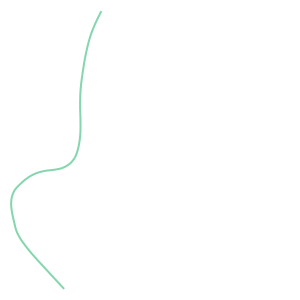

In [28]:
traffic[15]